In [0]:
import sys
sys.path.append('../')

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from CustomRNN import PrunedDeepRNN

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Import, shuffle and split dataset

In [0]:
data = pd.read_csv('reber_sequences.csv')

In [0]:
data = data.sample(frac=1).reset_index(drop=True)

In [0]:
train_data = data[:int(.75*len(data))]
test_data = data[len(train_data):]

In [6]:
print('Total length: {}\nTrain data length: {}\nTest data length: {}'.format(len(data), len(train_data), len(test_data)))

Total length: 25000
Train data length: 18750
Test data length: 6250


#### Parameters

In [0]:
BATCH_SIZE = 16
EPOCHS = 12
OUTPUT_SIZE = 2
INPUT_SIZE = 128

#### Customize `Dataset` and create loaders

In [0]:
class MakeDataset(Dataset):
    def __init__(self, data):
        self.strings = list(data['string'])
        self.valid = list(data['valid'])
        self.len = len(self.valid)
        self.valid_list = [0, 1]

    def __getitem__(self, index):
        return self.strings[index], self.valid[index]

    def __len__(self):
        return self.len

Create train loader

In [0]:
dataset = MakeDataset(train_data)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

Create test loader

In [0]:
dataset = MakeDataset(test_data)
test_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Some helper functions

In [0]:
def create_variable(tensor):
    return Variable(tensor)

In [0]:
def pad_seq(vect_seqs, seq_lens, valid):
    seq_tensor = torch.zeros((len(vect_seqs), seq_lens.max())).long()
    
    for index, (seq, seq_len) in enumerate(zip(vect_seqs, seq_lens)):
        seq_tensor[index, :seq_len] = torch.LongTensor(seq)
        
    return create_variable(seq_tensor), create_variable(seq_lens), create_variable(valid)

In [0]:
def str2ascii(string):
    ascii_arr = [ord(s) for s in string]
    return ascii_arr, len(ascii_arr)

In [0]:
def make_variables(strings, valid):
    seqs_and_lens = [str2ascii(string)for string in strings]
    vect_seqs = [s[0] for s in seqs_and_lens]
    seq_lens = torch.LongTensor([s[1] for s in seqs_and_lens])
    valid = torch.LongTensor(valid)
    return pad_seq(vect_seqs, seq_lens, valid)

#### Define model class

In [0]:
class RNNModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers : list, mode, theta=None):
        super(RNNModel, self).__init__()

        self.embedding = nn.Embedding(input_size, hidden_layers[0])
        self.rnn = PrunedDeepRNN(hidden_layers[0], hidden_layers, mode=mode, theta=theta)
        self.fc = nn.Linear(hidden_layers[-1], output_size)
        
    def forward(self, input):
        input = input.t()
        embedded = self.embedding(input)

        output, hiddens = self.rnn(embedded)

        output = self.fc(output[-1])
        return output, hiddens

#### Training function

In [0]:
def train():
    total_loss = 0
    
    for i, (string, valid) in enumerate(train_loader, 1):
        input, seq_lens, target = make_variables(string, valid)

        output, _ = classifier(input)
        
        loss = criterion(output, target)
        total_loss += loss.data.item()
        
        classifier.zero_grad()
        loss.backward()
        optimizer.step()

#### Testing function

In [0]:
def test():
    correct = 0
    test_data_size = len(test_loader.dataset)
    
    for string, valid in test_loader:
        input, seq_lens, target = make_variables(string, valid)

        output, _ = classifier(input)

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    acc = 100 * correct.item() / test_data_size
    test_acc.append(acc)

#### Time for action!

#### Base RNN

In [0]:
modes = ['GRU', 'Pruned GRU']
accuracies = []

In [19]:
%%time
for mode in modes:
    mode_acc = []
    print('{}\n{}'.format(mode, 12*'-'), end='')
    split_mode = mode.replace('-', ' ').split()

    for i in range(12):
        print('\nRun {}:'.format(i+1), end=' ')

        if split_mode[0] == 'Pruned':
            classifier = RNNModel(INPUT_SIZE, 2, [100, 100, 100], split_mode[-1], theta=0.01)
        else:
            classifier = RNNModel(INPUT_SIZE, 2, [100, 100, 100], split_mode[-1])

        optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        test_acc = []
        for epoch in range(1, EPOCHS+1):
            print('{}'.format(epoch), end=' ')
            train()
            test()

        mode_acc += test_acc
    accuracies.append(mode_acc)
    print('\n')

GRU
------------
Run 1: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 2: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 3: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 4: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 5: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 6: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 7: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 8: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 9: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 10: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 11: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 12: 1 2 3 4 5 6 7 8 9 10 11 12 

Pruned GRU
------------
Run 1: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 2: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 3: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 4: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 5: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 6: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 7: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 8: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 9: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 10: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 11: 1 2 3 4 5 6 7 8 9 10 11 12 
Run 12: 1 2 3 4 5 6 7 8 9 10 11 12 

CPU times: user 7h 56min 6s, sys: 7min 2s, total: 8h 3min 9s
Wall time: 8h 5min 18s


In [0]:
df = pd.DataFrame(list(zip(*accuracies)), columns=modes)

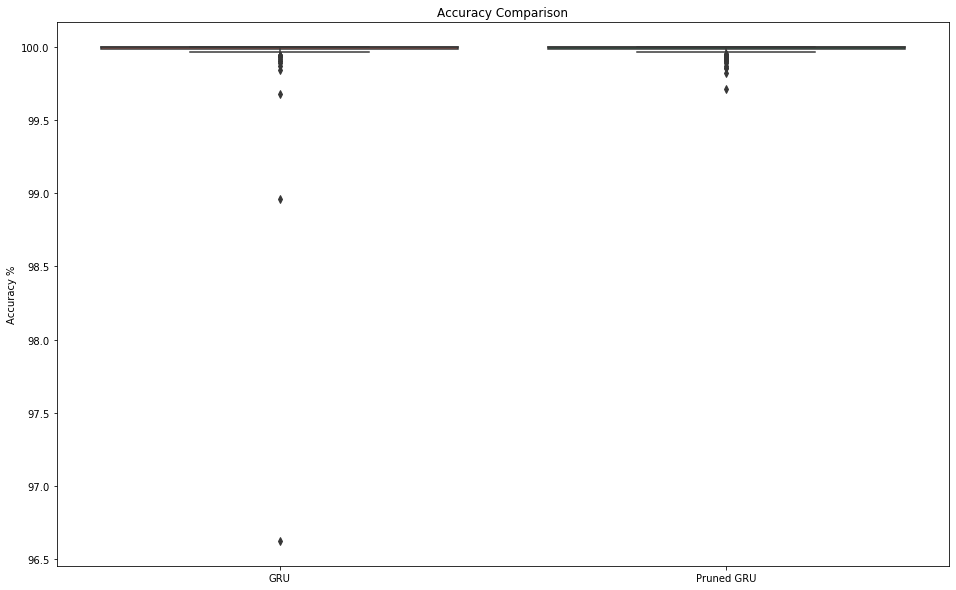

In [21]:
plt.figure(figsize=(16, 10))
plt.ylabel('Accuracy %')
plt.title('Accuracy Comparison')
sns.boxplot(data=df, palette=['tomato', 'seagreen'])
plt.savefig('gru_accuracy_comparison.png')
plt.show()

In [0]:
with open('accuracies.txt', 'a') as f:
    for i in range(len(modes)):
        f.write(modes[i] + ':' + ','.join(str(a) for a in accuracies[i]) + '\n')